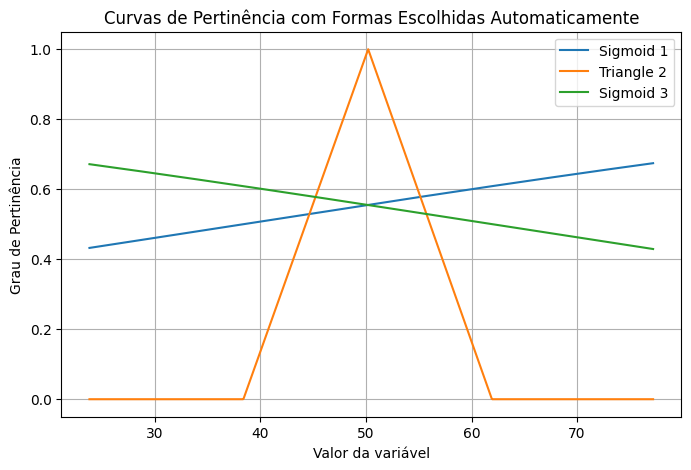

In [5]:
import numpy as np
import skfuzzy as fuzz
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Simulação de dados contínuos
np.random.seed(42)
data = np.random.normal(50, 10, 200)

# Parâmetros
n_clusters = 3
x = np.linspace(data.min(), data.max(), 1000)

# Aplicar KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(data.reshape(-1, 1))
centers = np.sort(kmeans.cluster_centers_.flatten())

# Avaliar dispersão dos centros
distances = np.diff(centers)
mean_distance = np.mean(distances)
std_distance = np.std(distances)

# Função para escolher tipo de curva automaticamente
def choose_shape(i, n, distances, std, threshold=0.2):
    # Últimas curvas: usar sigmoid para suavizar bordas
    if i == 0 or i == n - 1:
        return 'sigmoid'
    # Se dispersão dos centros for baixa, usar triangular
    if std / mean_distance < threshold:
        return 'triangle'
    else:
        return 'trapezoid'

# Criar funções de pertinência
membership_functions = []
for i in range(n_clusters):
    shape = choose_shape(i, n_clusters, distances, std_distance)
    if shape == 'triangle':
        if i == 0:
            mf = fuzz.trimf(x, [x.min(), centers[i], centers[i+1]])
        elif i == n_clusters - 1:
            mf = fuzz.trimf(x, [centers[i-1], centers[i], x.max()])
        else:
            mf = fuzz.trimf(x, [centers[i-1], centers[i], centers[i+1]])
    elif shape == 'trapezoid':
        if i == 0:
            mf = fuzz.trapmf(x, [x.min(), x.min(), centers[i], centers[i+1]])
        elif i == n_clusters - 1:
            mf = fuzz.trapmf(x, [centers[i-1], centers[i], x.max(), x.max()])
        else:
            mf = fuzz.trapmf(x, [centers[i-1], centers[i-1], centers[i], centers[i+1]])
    elif shape == 'sigmoid':
        direction = 1 if i == 0 else -1  # cresce ou decresce
        mf = fuzz.sigmf(x, centers[i], direction * 1.0 / (x.max() - x.min()))
    membership_functions.append((shape, mf))

# Visualizar
plt.figure(figsize=(8, 5))
for i, (shape, mf) in enumerate(membership_functions):
    plt.plot(x, mf, label=f'{shape.capitalize()} {i+1}')
plt.title('Curvas de Pertinência com Formas Escolhidas Automaticamente')
plt.xlabel('Valor da variável')
plt.ylabel('Grau de Pertinência')
plt.legend()
plt.grid(True)
plt.show()


c:\Users\alexa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Acurácia NEFCLASS: 1.00
F1-Score NEFCLASS: 1.00


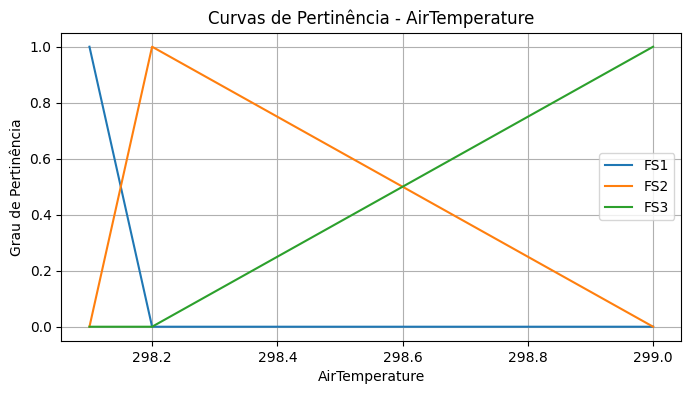

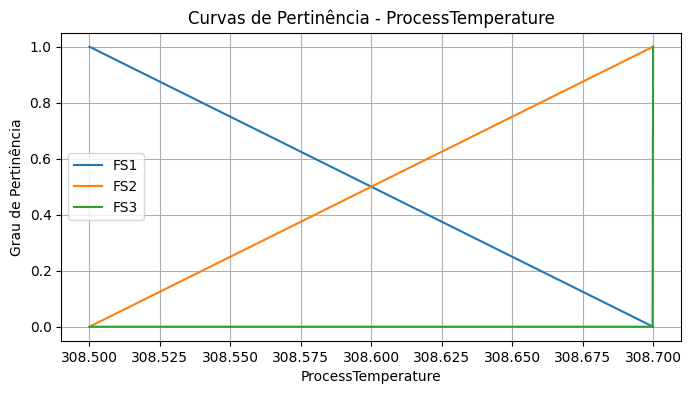

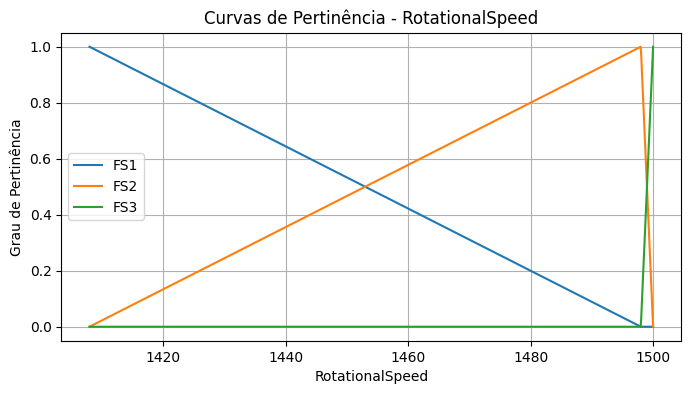

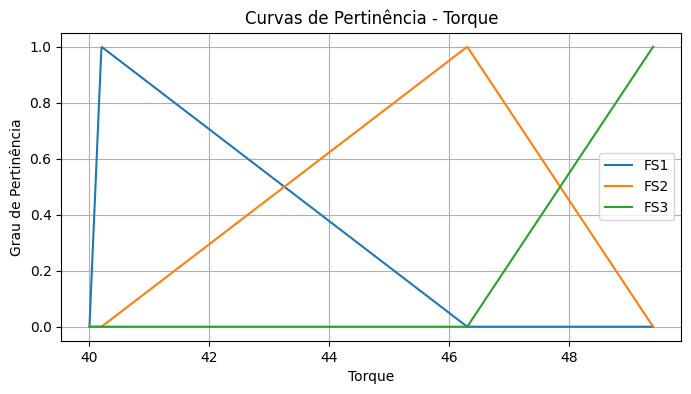

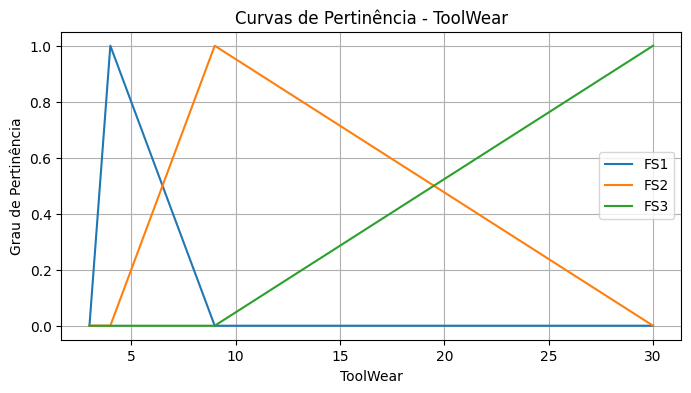

In [6]:
import numpy as np
import skfuzzy as fuzz
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
from collections import defaultdict

# Carregar o dataset simulado (substitua por leitura real se necessário)
data = pd.DataFrame({
    'AirTemperature': [298.1, 298.2, 298.1, 298.2, 298.2] + [299.0]*9995,
    'ProcessTemperature': [308.6, 308.7, 308.5, 308.6, 308.7] + [308.7]*9995,
    'RotationalSpeed': [1551, 1408, 1498, 1433, 1408] + [1500]*9995,
    'Torque': [42.8, 46.3, 49.4, 39.5, 40.0] + [40.2]*9995,
    'ToolWear': [0, 3, 5, 7, 9] + [30]*9995,
    'Target': [0, 0, 0, 0, 0] + [0]*9995
})

X = data.iloc[:, :-1].values
y = data['Target'].values

# Dividir os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

features = data.columns[:-1].tolist()
n_clusters = 3

# Etapa 1: Gerar funções de pertinência usando KMeans e definir rótulos fuzzy
def create_fuzzy_sets(X_train):
    fuzzy_sets = {}
    set_labels = {}
    for i, feature in enumerate(features):
        values = X_train[:, i]
        kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(values.reshape(-1, 1))
        centers = np.sort(kmeans.cluster_centers_.flatten())
        x_range = np.linspace(values.min(), values.max(), 1000)
        funcs = []
        labels = []
        for j in range(n_clusters):
            if j == 0:
                mf = fuzz.trimf(x_range, [values.min(), centers[j], centers[j+1]])
            elif j == n_clusters - 1:
                mf = fuzz.trimf(x_range, [centers[j-1], centers[j], values.max()])
            else:
                mf = fuzz.trimf(x_range, [centers[j-1], centers[j], centers[j+1]])
            funcs.append(mf)
            labels.append(f"{feature}_FS{j}")
        fuzzy_sets[feature] = (x_range, funcs)
        set_labels[feature] = labels
    return fuzzy_sets, set_labels

# Etapa 2: Gerar regras fuzzy baseadas em dados
fuzzy_sets, set_labels = create_fuzzy_sets(X_train)

rules = defaultdict(list)
for i in range(len(X_train)):
    input_set = []
    for j, feature in enumerate(features):
        val = X_train[i, j]
        x_range, mfs = fuzzy_sets[feature]
        memberships = [fuzz.interp_membership(x_range, mf, val) for mf in mfs]
        idx = np.argmax(memberships)
        input_set.append(set_labels[feature][idx])
    rules[tuple(input_set)].append(y_train[i])

# Reduzir as regras para a classe mais comum
fuzzy_rules = {rule: max(set(labels), key=labels.count) for rule, labels in rules.items()}

# Etapa 3: Classificação

def classify(x, fuzzy_sets, set_labels, rules):
    input_set = []
    for j, feature in enumerate(features):
        val = x[j]
        x_range, mfs = fuzzy_sets[feature]
        memberships = [fuzz.interp_membership(x_range, mf, val) for mf in mfs]
        idx = np.argmax(memberships)
        input_set.append(set_labels[feature][idx])
    return rules.get(tuple(input_set), 0)  # Classe padrão 0

# Avaliação
y_pred = [classify(x, fuzzy_sets, set_labels, fuzzy_rules) for x in X_test]
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Acurácia NEFCLASS: {acc:.2f}")
print(f"F1-Score NEFCLASS: {f1:.2f}")

# Visualização das curvas de pertinência
for i, feature in enumerate(features):
    plt.figure(figsize=(8, 4))
    x_range, mfs = fuzzy_sets[feature]
    for j, mf in enumerate(mfs):
        plt.plot(x_range, mf, label=f"FS{j+1}")
    plt.title(f"Curvas de Pertinência - {feature}")
    plt.xlabel(feature)
    plt.ylabel("Grau de Pertinência")
    plt.legend()
    plt.grid(True)
    plt.show()


Forma MISTA
Acurácia: 0.96
F1-Score: 0.95



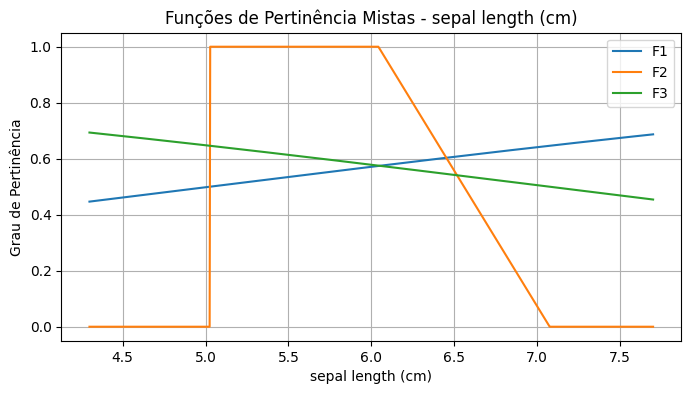

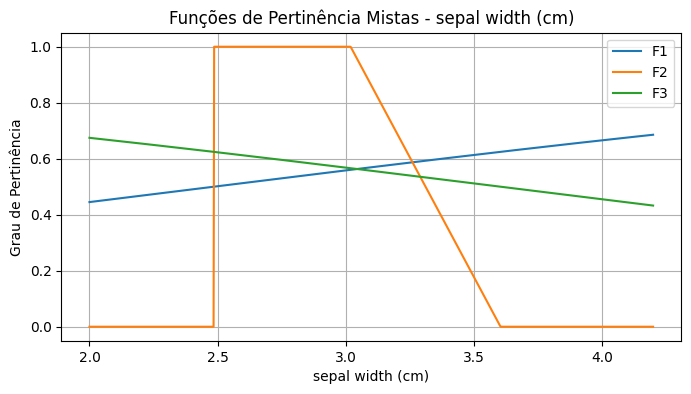

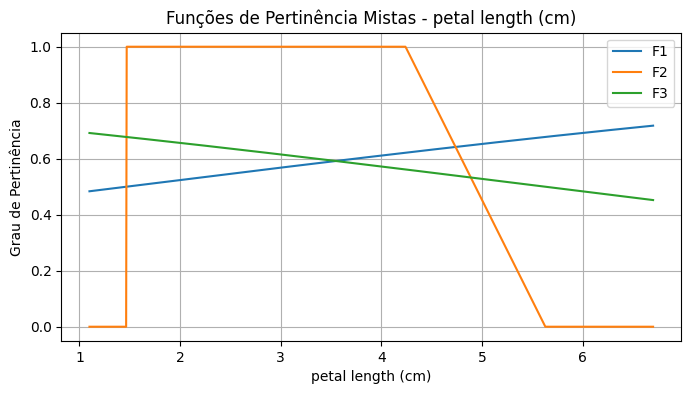

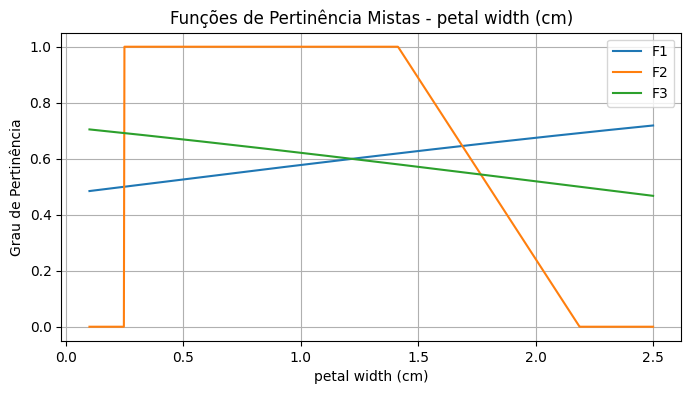

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cluster import KMeans
from collections import defaultdict

# Função para criar curvas de pertinência misturadas

def criar_curvas_fuzzy_mistas(X_train, feature_names, n_clusters=3):
    fuzzy_sets = {}
    labels = {}
    for i, feature in enumerate(feature_names):
        data = X_train[:, i]
        x_range = np.linspace(data.min(), data.max(), 1000)
        kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(data.reshape(-1, 1))
        centers = np.sort(kmeans.cluster_centers_.flatten())
        funcs = []
        names = []
        for j in range(n_clusters):
            if j == 0:
                mf = fuzz.sigmf(x_range, centers[j], 1.0 / (x_range.max() - x_range.min()))
            elif j == n_clusters - 1:
                mf = fuzz.sigmf(x_range, centers[j], -1.0 / (x_range.max() - x_range.min()))
            elif j % 2 == 0:
                mf = fuzz.trimf(x_range, [centers[j-1], centers[j], centers[j+1]])
            else:
                mf = fuzz.trapmf(x_range, [centers[j-1], centers[j-1], centers[j], centers[j+1]])
            funcs.append(mf)
            names.append(f"{feature}_F{j}")
        fuzzy_sets[feature] = (x_range, funcs)
        labels[feature] = names
    return fuzzy_sets, labels

# Função para gerar regras fuzzy
def gerar_regras_fuzzy(X_train, y_train, fuzzy_sets, labels, feature_names):
    regras = defaultdict(list)
    for idx in range(len(X_train)):
        entrada = []
        for i, feature in enumerate(feature_names):
            x = X_train[idx, i]
            x_range, funcs = fuzzy_sets[feature]
            graus = [fuzz.interp_membership(x_range, mf, x) for mf in funcs]
            idx_max = np.argmax(graus)
            entrada.append(labels[feature][idx_max])
        regras[tuple(entrada)].append(y_train[idx])
    regras_final = {k: max(set(v), key=v.count) for k, v in regras.items()}
    return regras_final

# Função de classificação
def classificar_fuzzy(x, fuzzy_sets, labels, regras, feature_names):
    entrada = []
    for i, feature in enumerate(feature_names):
        x_range, funcs = fuzzy_sets[feature]
        graus = [fuzz.interp_membership(x_range, mf, x[i]) for mf in funcs]
        idx_max = np.argmax(graus)
        entrada.append(labels[feature][idx_max])
    return regras.get(tuple(entrada), 0)

# Função principal para executar o experimento com curvas mistas
def executar_experimento_misto():
    iris = load_iris()
    X = iris.data
    y = iris.target
    feature_names = iris.feature_names
    class_names = iris.target_names
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    fuzzy_sets, labels = criar_curvas_fuzzy_mistas(X_train, feature_names)
    regras = gerar_regras_fuzzy(X_train, y_train, fuzzy_sets, labels, feature_names)
    y_pred = [classificar_fuzzy(x, fuzzy_sets, labels, regras, feature_names) for x in X_test]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Forma MISTA")
    print(f"Acurácia: {acc:.2f}")
    print(f"F1-Score: {f1:.2f}\n")

    # Visualização
    for i, feature in enumerate(feature_names):
        plt.figure(figsize=(8, 4))
        x_range, funcs = fuzzy_sets[feature]
        for j, mf in enumerate(funcs):
            plt.plot(x_range, mf, label=f'F{j+1}')
        plt.title(f'Funções de Pertinência Mistas - {feature}')
        plt.xlabel(feature)
        plt.ylabel('Grau de Pertinência')
        plt.legend()
        plt.grid(True)
        plt.show()

# Executar o experimento com curvas mistas
executar_experimento_misto()


In [4]:
########################################################################
# Treinamento do Agente
########################################################################
Recompensa, \
Q, \
Ambiente = Suporte_Calculo.Executa (
    10000, 
    Epsilon, 
    Taxa_Aprendizado, 
    Fator_Desconto, 
    Taxa_Decaimento_Epsilon, 
    Gerador_Aleatorio,
    Treinamento=True, 
    Exibir_Interface=False, 
    Diretorio_Modelo='..\\Modelos\\ModeloTreinamentoSarsa.pkl', 
    render=False 
)   



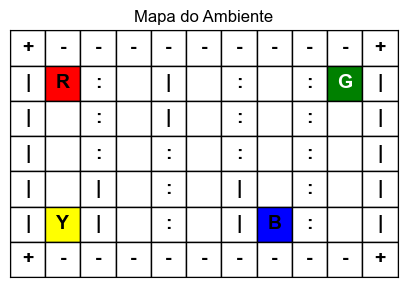

In [5]:
########################################################################
# Mostra o Mapa do Ambiente Utilizado
########################################################################
Suporte_Ambiente.Mostra_Ambiente ( 
   Ambiente, 
   Exportar_Imagem=True, 
   Diretorio_Grafico='..\\Output\\'
)



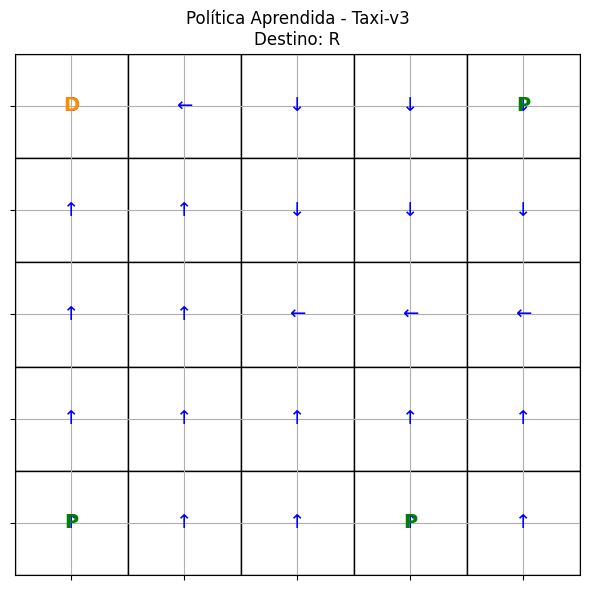

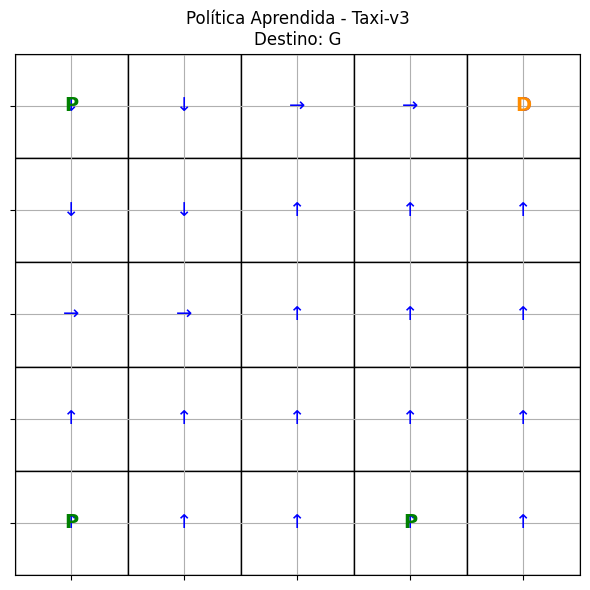

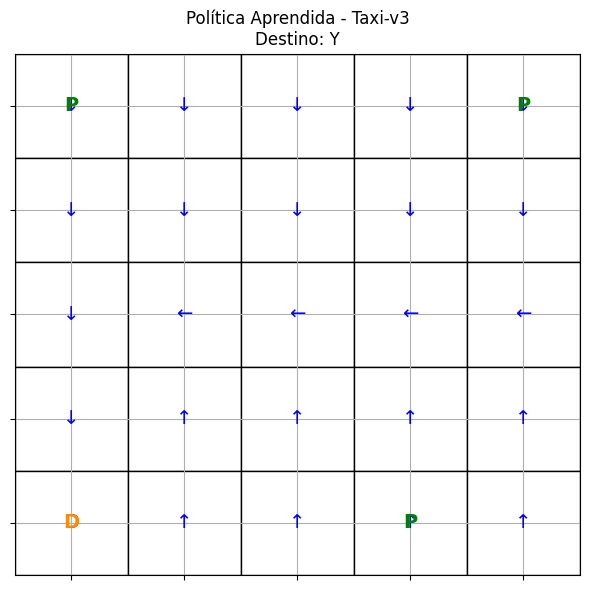

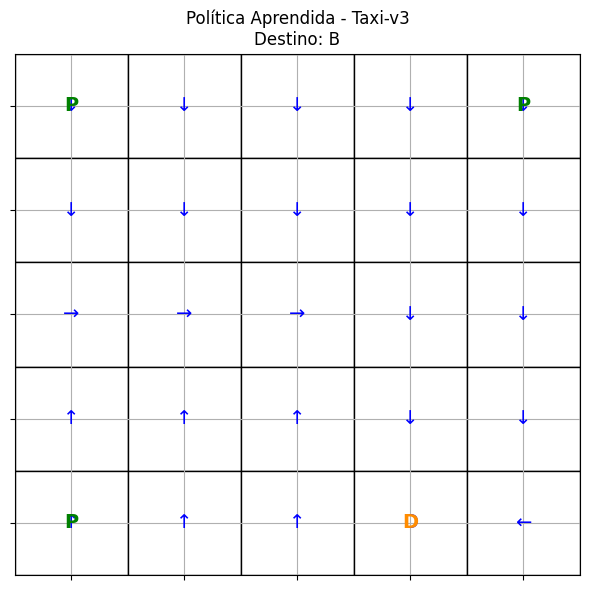

In [6]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle

def extrair_politica(q_tabela):
    return np.argmax(q_tabela, axis=1)

def mostrar_politica_taxi(q_tabela, titulo_base="Política Aprendida - Taxi-v3"):
    env = gym.make("Taxi-v3")
    politica = extrair_politica(q_tabela)
    direcoes = ['↓', '↑', '→', '←', 'P', 'D']  # Ações possíveis

    # Locais de parada (mesmo que env.locs): R, G, Y, B
    pontos = {
        0: ('R', (0, 0)),  # Red
        1: ('G', (0, 4)),  # Green
        2: ('Y', (4, 0)),  # Yellow
        3: ('B', (4, 3))   # Blue
    }

    for destino in range(4):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xlim(-0.5, 4.5)
        ax.set_ylim(-0.5, 4.5)
        ax.set_xticks(np.arange(5))
        ax.set_yticks(np.arange(5))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(True)

        for row in range(5):
            for col in range(5):
                estado = env.unwrapped.encode(row, col, 4, destino)  # passageiro na posição 4 = "não embarcado"
                acao = politica[estado]
                seta = direcoes[acao]
                ax.text(col, 4 - row, seta, ha='center', va='center', fontsize=14, color='blue')
                ax.add_patch(plt.Rectangle((col - 0.5, 4 - row - 0.5), 1, 1, edgecolor='black', facecolor='white'))

        # Marcar o ponto de pickup (onde o passageiro está inicialmente)
        for pid, (nome, (r, c)) in pontos.items():
            if pid == destino:
                # Destino → D
                ax.text(c, 4 - r, 'D', ha='center', va='center', fontsize=14, color='darkorange', fontweight='bold')
            else:
                # Possíveis pickups → P
                ax.text(c, 4 - r, 'P', ha='center', va='center', fontsize=14, color='green', fontweight='bold')

        ax.set_title(f"{titulo_base}\nDestino: {pontos[destino][0]}")
        plt.tight_layout()
        plt.show()

# === Exemplo de uso ===
with open("..\\Modelos\\ModeloTreinamentoSarsa.pkl", "rb") as f:
    q_tabela = pickle.load(f)

mostrar_politica_taxi(q_tabela)



In [7]:
########################################################################
# Mostra Política Aprendida
########################################################################
Suporte_Politica.Mostra_Politica (
    Ambiente, 
    Exporta_Imagem=True, 
    Diretorio_Modelo='..\\Modelos\\ModeloTreinamentoSarsa.pkl', 
    Diretorio_Grafico='..\\Output\\'
    )


IndexError: list index out of range

In [8]:
########################################################################
# Mostra Valores Q da Ação Ótima
########################################################################
Suporte_Valores.Mostra_Valores_Q ( 
    Ambiente, 
    Exporta_Imagem=True, 
    Diretorio_Modelo='..\\Modelos\\ModeloTreinamentoSarsa.pkl', 
    Diretorio_Grafico='..\\Output\\'
    )



ValueError: cannot reshape array of size 500 into shape (7,7)

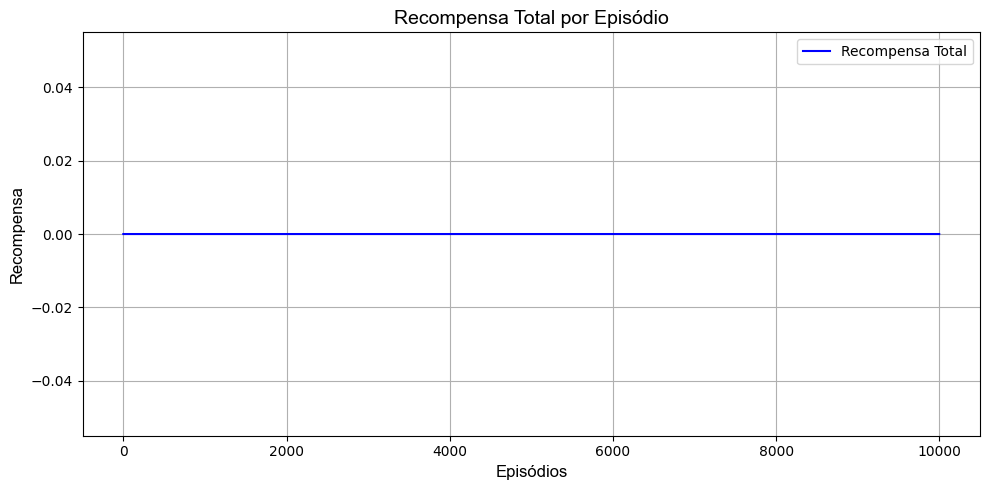

In [9]:
########################################################################
# Mostra a Recompensa Total por Episódio
########################################################################
Suporte_Recompensa.Mostra_Recompensa (
    Recompensa,     
    Exporta_Imagem=True,
    Diretorio_Grafico='..\\Output\\'
    )


In [9]:
########################################################################
# FIM DO PROGRAMA
########################################################################